# ELECTROCARDIOGRAM - P-WAVE DETECTION
Hisham Ben Hamidane and Ludovic Le Reste

TBD:
- fix annotation of precision and recall and fitting a new model (increment_x)
- use ipywidgets to plot results instead of matplotlib widgets Slider
- improve quality of plots in further work section
- add new metric

check if this works on work PC

## Load packages and files

In [1]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import signal
import time
from matplotlib.widgets import Slider

# interactivity options: ‘all’, ‘last’, ‘last_expr’ or ‘none’, ‘last_expr_or_assign’
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

C:\Users\ludov\miniconda3\envs\env_tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ludov\miniconda3\envs\env_tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ludov\miniconda3\envs\env_tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ludov\miniconda3\envs\

In [2]:
# %% LOAD FILES
path = "D:\Ludo\Docs\programming\CAS_applied_data_science\CAS-Applied-Data-Science-master\Module-6\Electrocardiogram_analysis\Assignments\ECG\www.physionet.org\physiobank\database".replace("\\", "/")
# path = r"C:\Users\ludovic.lereste\Documents\CAS_applied_data_science\CAS-Applied-Data-Science-master\Module-6\Electrocardiogram_analysis\Assignments\ECG\www.physionet.org\physiobank\database".replace("\\", "/")
os.chdir(path)

record = wfdb.rdrecord("mitdb/100")
ann = wfdb.rdann("mitdb/100", "pwave")
atr = wfdb.rdann("mitdb/100", "atr")

record.__dict__
ann.__dict__.items()
atr.__dict__.items()

ecg = record.p_signal[:, 0]
ecg_v5 = record.p_signal[:, 1]

# translate discrete p-wave annotation into digital signal
# p-wave is +-width around annotation
p_ts = np.zeros(record.sig_len, dtype=int)
width = 6
for i in ann.sample:
    p_ts[max(i-width, 0):min(i+width, record.sig_len)] = 1
    
# translate discrete r-wave annotation into digital signal
# r-wave is +-width around annotation
r_ts = np.zeros(record.sig_len, dtype=int)
width = 6
for i in atr.sample:
    r_ts[max(i-width, 0):min(i+width, record.sig_len)] = 1

# Generate time vector
fq = 360
t = np.linspace(start=0, stop=ecg.size/fq, num=ecg.size)
tss = np.vstack((t, ecg, p_ts)).T

## Data exploration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


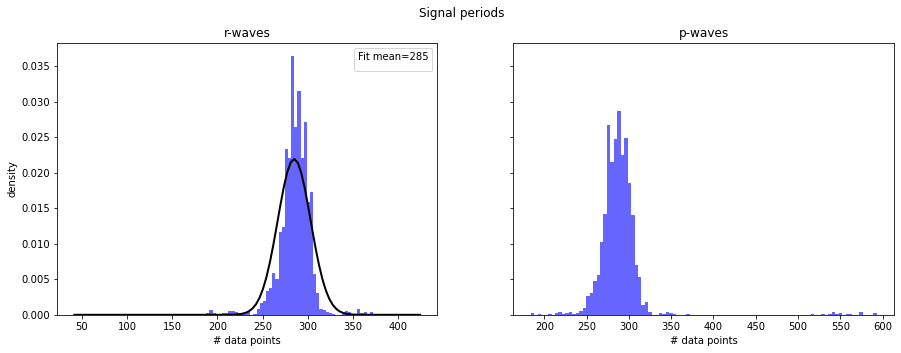

There are 1 r-wave periods longer than 400 data points
There are 16 p-wave periods longer than 400 data points


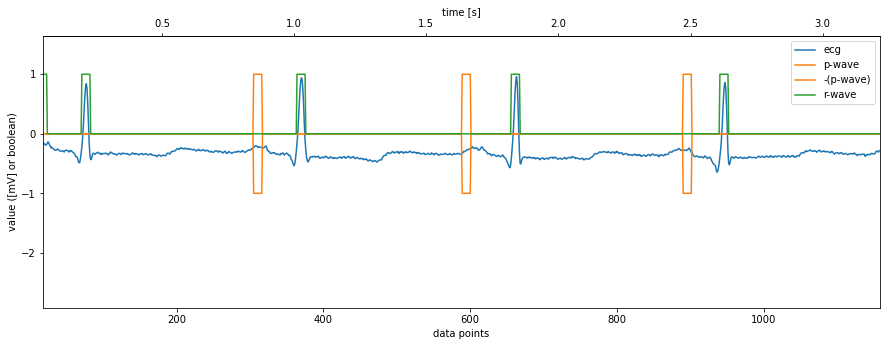

In [3]:
# %% EXPLORE DATA
# Analyse heartbeats periods
period = np.diff(atr.sample)
period_p = np.diff(ann.sample)

# Fit a normal distribution to period distribution
mu, std = norm.fit(period) 
period_mean = int(mu)
  
mu_p, std_p = norm.fit(period_p) 
period_mean_p = int(mu_p)

# Plot the histogram and Probability Density Function.
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

axs[0].hist(period, bins=100, density=True, alpha=0.6, color='b')
x_min, x_max = axs[0].get_xlim()
x_prob = np.linspace(x_min, x_max, 100)
prob = norm.pdf(x_prob, period_mean, std)
axs[0].plot(x_prob, prob, 'k', linewidth=2)
axs[0].set_xlabel('# data points')
axs[0].set_ylabel('density')
axs[0].legend(title=f"Fit mean={period_mean}")
axs[0].set_title("r-waves")

axs[1].hist(period_p, bins=100, density=True, alpha=0.6, color='b')
axs[1].set_xlabel('# data points')
axs[1].set_title('p-waves')

fig.suptitle('Signal periods')
plt.show()

"""
N.B.:
    There are a few (16) heartbeats with no p-wave annotated
    There is only one weird heartbeat (lasting 407 samples: heartbeat # 1907)
"""
print(f"There are {np.count_nonzero(period > 400)} r-wave periods longer than 400 data points")
print(f"There are {np.count_nonzero(period_p > 400)} p-wave periods longer than 400 data points")

# Plot time series
n_samples = period_mean*4
heartbeats = np.where(period>00)[0]
case = 1
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ecg, label='ecg')
ax.plot(p_ts, label='p-wave')
ax.plot(p_ts*-1, label='-(p-wave)', color='C1')
ax.plot(r_ts, label='r-wave')
ax.set_xlim([atr.sample[heartbeats[case]-1], atr.sample[heartbeats[case]-1]+ n_samples])
# plt.xlim([0, n_samples])
ax.set_xlabel('data points')
ax.set_ylabel('value ([mV] or boolean)')
secax = ax.secondary_xaxis('top', functions=(lambda x: x/fq, lambda x: x*fq))
secax.set_xlabel('time [s]')
plt.legend()
plt.show()

## Prepare data for neural networks
1- split time series into chunks of same size (called packets)
* The start index of each packet is chosen randomly
    
2- split the packets for training and test

In [4]:
# %% PREP DATA
"""
Split data into packets of same length to feed to the model
The start of the chunk isi randomly chosen
remove the first (weird annotation) and the last two heartbeats (for dimension consistency)
"""
packet_length = 300
sampling = 2
packet_length_ds = ecg[: packet_length : sampling].shape[0]
ecg_packets = np.zeros(shape=(int(ecg.shape[0]/packet_length), packet_length_ds))
p_ts_packets = np.zeros(shape=ecg_packets.shape, dtype=int)

for i in range(ecg_packets.shape[0]):
    offset = np.random.randint(low=0, high=ecg.shape[0]-packet_length)
    ecg_packets[i, :] = ecg[offset : offset+packet_length : sampling]
    p_ts_packets[i, :] = p_ts[offset : offset+packet_length : sampling]

# split train, test
perc_split = 0.8
n_inputs = ecg_packets.shape[0]
ecg_packets_train = ecg_packets[0:int(n_inputs*perc_split)]
ecg_packets_test = ecg_packets[int(n_inputs*perc_split):-1]
p_ts_packets_train = p_ts_packets[0:int(n_inputs*perc_split)]
p_ts_packets_test = p_ts_packets[int(n_inputs*perc_split):-1]

## Dense neural networks

In [5]:
# %% MODEL 1: Dense neural network - simplest model (1 layer)
# Build model
d_mult = "single_layer"

d_input = ecg_packets.shape[1]
x = tf.keras.layers.Input(dtype='float64', shape=d_input)
   
lay_1 = tf.keras.layers.Dense(units=d_input, activation='sigmoid', name='L1')(x)

#prediction: probability->integer
# pred = 

#TBD: adding pred to the model output prudces an error (expected int64, instead had float)
model = tf.keras.Model(inputs=x, outputs=[lay_1])

model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
L1 (Dense)                   (None, 150)               22650     
Total params: 22,650
Trainable params: 22,650
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# %% MODEL 2: Dense neural network - 2 layers
# Build model
d_mult = 1.0

d_input = ecg_packets.shape[1]
x = tf.keras.layers.Input(dtype='float64', shape=d_input)

lay_1 = tf.keras.layers.Dense(units=int(d_input*d_mult), activation='relu', name='L1')(x)
lay_2 = tf.keras.layers.Dense(units=d_input, activation='sigmoid', name='L2')(lay_1)

#prediction: probability->integer
# pred = 

#TBD: adding pred to the model output prudces an error (expected int64, instead had float)
model = tf.keras.Model(inputs=x, outputs=[lay_2])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
L1 (Dense)                   (None, 150)               22650     
_________________________________________________________________
L2 (Dense)                   (None, 150)               22650     
Total params: 45,300
Trainable params: 45,300
Non-trainable params: 0
_________________________________________________________________


In [7]:
# %% MODEL 3: Convolutional neural network
"""let's try one feature map (1D-line) followed by one dense layer
and maybe try to transform the dense layer into a convolutional layer of correct size

testing:
data = tf.keras.utils.timeseries_dataset_from_array(data=tss,
                                                    targets=None,
                                                    sequence_length=300,
                                                    sequence_stride=300,
                                                    sampling_rate=1)
for el in data:
    inputs = el
    """
# lay_1 = tf.keras.layers.Conv1D()
# tf.keras.layers.MaxPool1D()

"let's try one feature map (1D-line) followed by one dense layer\nand maybe try to transform the dense layer into a convolutional layer of correct size\n\ntesting:\ndata = tf.keras.utils.timeseries_dataset_from_array(data=tss,\n                                                    targets=None,\n                                                    sequence_length=300,\n                                                    sequence_stride=300,\n                                                    sampling_rate=1)\nfor el in data:\n    inputs = el\n    "

In [8]:
# %% TRAIN MODEL
batch_size = 50

start = time.time()
hist = model.fit(x=ecg_packets_train,
                    y=p_ts_packets_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(ecg_packets_test, p_ts_packets_test))
print(time.time()-start)

Train on 1732 samples, validate on 433 samples
Epoch 1/50
1732/1732 [==============================] - 0s 161us/sample - loss: 0.3633 - binary_accuracy: 0.8843 - precision: 0.0453 - recall: 0.0874 - val_loss: 0.1881 - val_binary_accuracy: 0.9590 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
1732/1732 [==============================] - 0s 79us/sample - loss: 0.1817 - binary_accuracy: 0.9580 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1745 - val_binary_accuracy: 0.9590 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
1732/1732 [==============================] - 0s 54us/sample - loss: 0.1743 - binary_accuracy: 0.9580 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1699 - val_binary_accuracy: 0.9590 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
1732/1732 [==============================] - 0s 58us/sample - loss: 0.1693 - binary_accuracy: 0.9580 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1641 - val_b

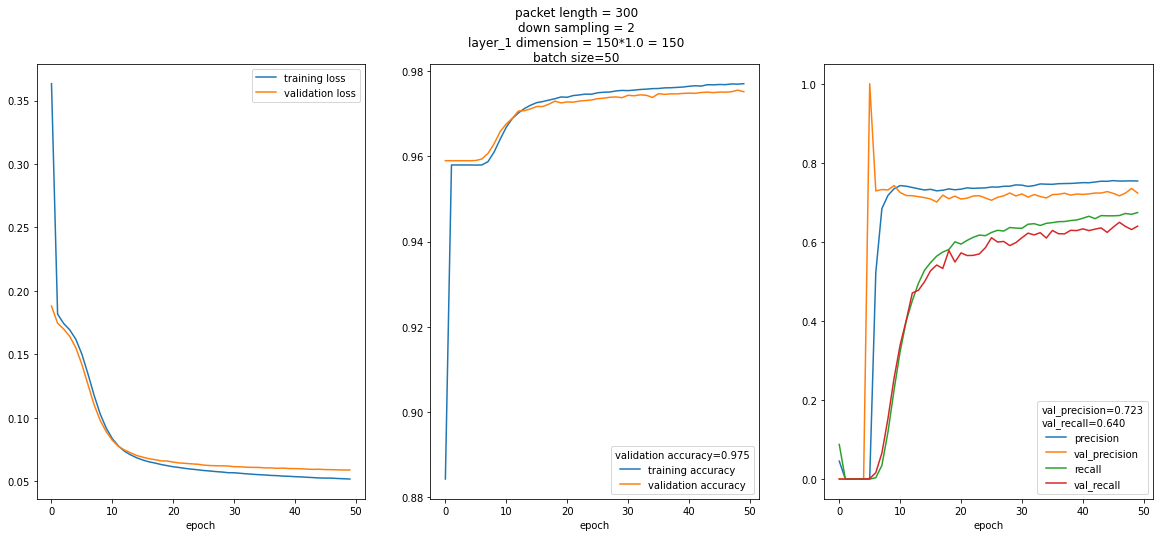

In [9]:
# %% PLOT RESULTS
"""N.B.: hist.params['batch_size'] does not work on Thermo's PC"""
fig, axs = plt.subplots(1, 3, figsize=(20,8))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[0].set_xlabel('epoch')

axs[1].plot(hist.epoch, hist.history['binary_accuracy'])
axs[1].plot(hist.epoch, hist.history['val_binary_accuracy'])
axs[1].legend(('training accuracy', 'validation accuracy'),
              title=f"validation accuracy={hist.history['val_binary_accuracy'][-1]:.3f}",
              loc='lower right')
axs[1].set_xlabel('epoch')

axs[2].plot(hist.epoch, hist.history['precision'])
axs[2].plot(hist.epoch, hist.history['val_precision'])
axs[2].plot(hist.epoch, hist.history['recall'])
axs[2].plot(hist.epoch, hist.history['val_recall'])
axs[2].legend(('precision', 'val_precision',
               'recall', 'val_recall'),
              title=f"val_precision={hist.history['val_precision'][-1]:.3f}\n"
              f"val_recall={hist.history['val_recall'][-1]:.3f}",
              loc='lower right')
axs[2].set_xlabel('epoch')

fig.suptitle(f"packet length = {packet_length}\n"
             f"down sampling = {sampling}\n"
             f"layer_1 dimension = {d_input}*{d_mult} = {int(d_input*d_mult)}\n"
             f"batch size={batch_size}")
plt.show()

!! TBD: use decorator @interact from ipywidgets (see https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html) instead of "from matplotlib.widgets import Sliders"

0

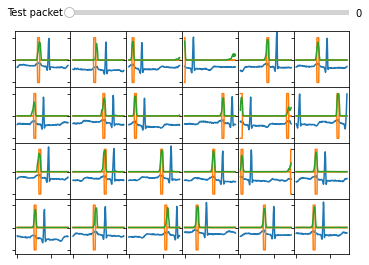

In [10]:
# %% EXAMINE RESULTS
"""N.B.: run %matplotlib auto in console"""
data = ecg_packets_test
data_ann = p_ts_packets_test
pred_test = model.predict(data)

n_rows = 4
n_cols = 6
n_plots = n_rows * n_cols
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True)
# plt.get_current_fig_manager().window.state('zoomed')
plt.subplots_adjust(top=0.90)

# inititate plot lines (ls_xxx) that will later be updated by the slider
ls_data = []
ls_data_ann = []
ls_data_ann2 = []
ls_pred_test = []
for i, ax in enumerate(axs.flat):
    ls_data.append(ax.plot(data[i, :]))
    ls_data_ann.append(ax.plot(data_ann[i, :]))
    ls_data_ann2.append(ax.plot(data_ann[i, :]*-1, color='C1'))
    ls_pred_test.append(ax.plot(pred_test[i, :]))
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylim(ymin=-1.2, ymax=1.3)
plt.subplots_adjust(wspace=0, hspace=0)

ax_slider = plt.axes([0.25, 0.95, 0.65, 0.03])
slider_packet = Slider(ax=ax_slider,
                       label='Test packet',
                       valmin=0,
                       valmax=data.shape[0]-n_plots,
                       valstep=n_plots,
                       valinit=0)

def update_slider(val):
    for i in np.arange(n_plots):
        ls_data[i][0].set_ydata(data[i+val, :])
        ls_data_ann[i][0].set_ydata(data_ann[i+val, :])
        ls_data_ann2[i][0].set_ydata(data_ann[i+val, :]*-1)
        ls_pred_test[i][0].set_ydata(pred_test[i+val, :])
        
slider_packet.on_changed(update_slider)

## Further work

Before feeding raw data to the neural network, one could transform the data and feed the raw and transformed data to the model.

Ideas to transform the data below:
- filtered signal
- spectrogram

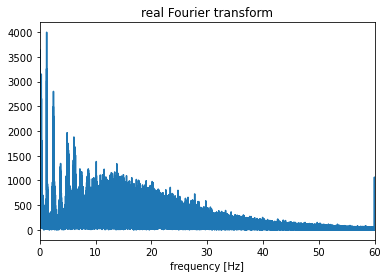

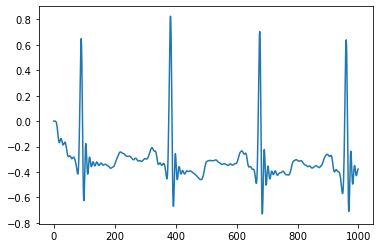

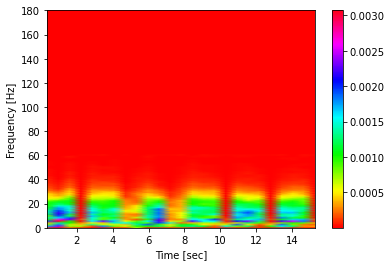

In [11]:
# Fourier transform
ecg_ft = np.fft.rfft(ecg)
f = np.fft.rfftfreq(ecg.size, d=1/fq)
plt.figure()
plt.plot(f[1:], np.abs(ecg_ft[1:]))
plt.xlim([0, 60])
plt.xlabel('frequency [Hz]')
plt.title('real Fourier transform')

# Filtering frequencies
# sos = signal.butter(N=10, Wn=[fq/50000, fq/50], btype='bandpass', output='sos', fs=fq)
sos = signal.butter(N=10, Wn=30, btype='lowpass', output='sos', fs=fq)
ecg_f = signal.sosfilt(sos, ecg)
plt.figure()
plt.plot(ecg_f[:1000])
# plt.plot(ecg_v5[:1000])

# Spectrogram
plt.figure()
spec_f, spec_t, spec_map = signal.spectrogram(ecg[:20*286], fq)
plt.pcolormesh(spec_t, spec_f, spec_map, shading='gouraud', cmap='hsv')
# plt.pcolormesh(spec_t[:10], spec_f[:], spec_map[:,:10], cmap='hsv')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()